In [1]:
import xarray as xr
import os
import pandas as pd
import tqdm
import numpy as np
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import cmocean

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# parameters cell
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links/']

input_names = ['HIST']
climatology_files = ['srf_rad_timmean.nc']
climatology_path = '/p/project/chhb19/streffing1/obs/era5/netcdf/'
exps = range(6, 8)
figsize=(12, 9)
dpi = 300
ofile = None
res = [720, 360]
variable = ['SSR','STR','SSHF','SLHF']
variable_clim = ['ssr','str','sshf','slhf']
accumulation_period=21600
levels = [-50,-30,-20,-10,-6,-2,2,6,10,20,30,50]

contour_outline_thickness = 0

In [99]:
# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [100]:
# Calculate Root Mean Square Deviation (RMSD)
def rmsd(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [101]:
# Mean Deviation
def md(predictions, targets):
    return (predictions - targets).mean()


In [76]:
# Load ERA5 reanalysis data

ERA5_data = OrderedDict()

for varc in variable_clim:
    ERA5_path = climatology_path+climatology_files[0]
    ERA5_data[varc] = cdo.yearmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(ERA5_path),returnArray=varc)/84600


In [77]:
# Load model data

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in variable:
        paths = []
        data[exp_name][v] = []
        for exp in tqdm.tqdm(exps):
            path = exp_path+'/'+v+'_'+f'{exp:05d}.nc'
            print(path)
            data[exp_name][v].append(cdo.yearmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(path),returnArray=v)/accumulation_period)

  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links//SSR_00006.nc


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1/2 [00:03<00:03,  3.36s/it]

/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links//SSR_00007.nc


  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links//STR_00006.nc


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1/2 [00:03<00:03,  3.32s/it]

/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links//STR_00007.nc


  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links//SSHF_00006.nc


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1/2 [00:03<00:03,  3.35s/it]

/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links//SSHF_00007.nc


  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links//SLHF_00006.nc


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1/2 [00:03<00:03,  3.48s/it]

/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links//SLHF_00007.nc


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.43s/it]


In [121]:
data_model = OrderedDict()
data_model_mean = OrderedDict()
data_reanalysis_mean = OrderedDict()


for exp_name in input_names:
    for var in variable:
        data_model_mean[exp_name,var]  = np.mean(data[exp_name][var],axis=0)
        if len(np.shape(data_model_mean[exp_name,var] )) > 2:
            data_model_mean[exp_name,var]  = np.mean(data_model_mean[exp_name,var] ,axis=0)
            
for varc in variable_clim:
    data_reanalysis_mean[varc] = np.mean(ERA5_data[varc],axis=0)



for var in variable:
    lon = np.arange(0, 360, 0.5)
    lat = np.arange(-90, 90, 0.5)
    data_model_mean[exp_name,var], lon = add_cyclic_point(data_model_mean[exp_name,var], coord=lon)


for varc in variable_clim:
    lon = np.arange(0, 360, 0.5)
    lat = np.arange(-90, 90, 0.5)
    data_reanalysis_mean[varc], lon = add_cyclic_point(data_reanalysis_mean[varc], coord=lon)

#rmsdval = rmsd(data_model_mean[exp_name],data_reanalysis_mean)
#mdval = md(data_model_mean[exp_name],data_reanalysis_mean)



NameError: name 'lon' is not defined

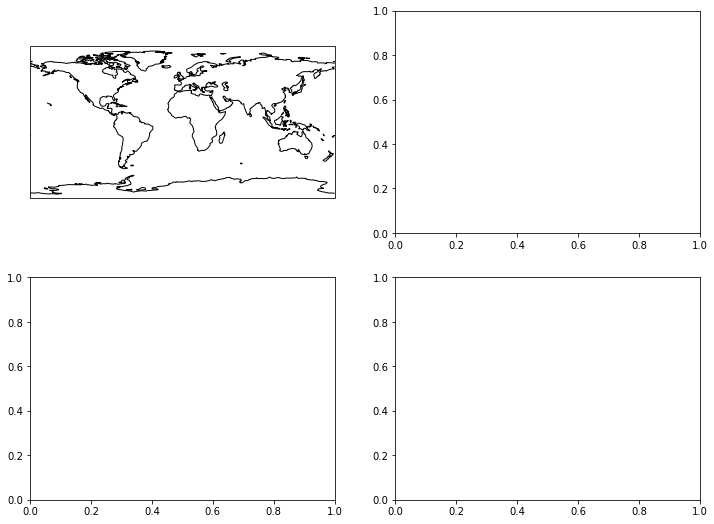

In [3]:

nrows, ncol = 2,2
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


for var, varc in zip(variable, variable_clim):
    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)
    
    
    imf=plt.contourf(lon, lat, data_model_mean[exp_name,var]-
                    data_reanalysis_mean[varc], cmap=plt.cm.PuOr_r, 
                    levels=levels, extend='both',
                    transform=ccrs.PlateCarree(),zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(lon, lat, data_model_mean[exp_name,var]-
                    data_reanalysis_mean[varc], colors=line_colors, 
                    levels=levels, linewidths=contour_outline_thickness,
                    transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('K')
    axes[i].set_xlabel('Simulation Year')
    
    #axes[i].set_title("AWI-CM3 model bias")
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False


    #plt.tight_layout() 
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
    cb.set_label(label="W/m²", size='14')
    cb.ax.tick_params(labelsize='12')
    #plt.text(5, 168, r'rmsd='+str(round(rmsdval,3)))
    #plt.text(-7.5, 168, r'bias='+str(round(mdval,3)))
    i = i+1
    
for label in cb.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=100.0)

ofile='heat_fluxes-era5'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')